In [ ]:
# advantages & idea of knowledge-based approach
    # baseline with low computational complexity -> several seconds for execution
    # transferability & transparency -> understanding of working mechanism feasible
    # introduce & include human knowledge as far as possible
        # reduce four bands to ndvi index
        # perform intial classification to get/focus on vegetation
        # structure is important (presumably esp. for veg height/volume)

# features
    # veg, ground, shadow share -> 7 features (first both for ndvi thres 0.3 & 0.4 & 0.5)
    # n_segments total, mean_size, mean_shape_idx & sd_size, sd_shape_idx for veg -> 10 features (each for two scales of segmentation) 

# possible extensions
    # calculate clustering of values (global & locals Moran's I)

In [43]:
# load standard libraries
import copy
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
import rasterio as rs
import rioxarray as rxr
import warnings
from tqdm import tqdm

# load segmentation/object-oriented libraries
import geopandas as gpd
from skimage.segmentation import felzenszwalb
from skimage.segmentation import mark_boundaries
from shapely.geometry import shape

# load rf & metrics libraries
from sklearn.ensemble import RandomForestRegressor
from torch import Tensor
import torchmetrics as metrics

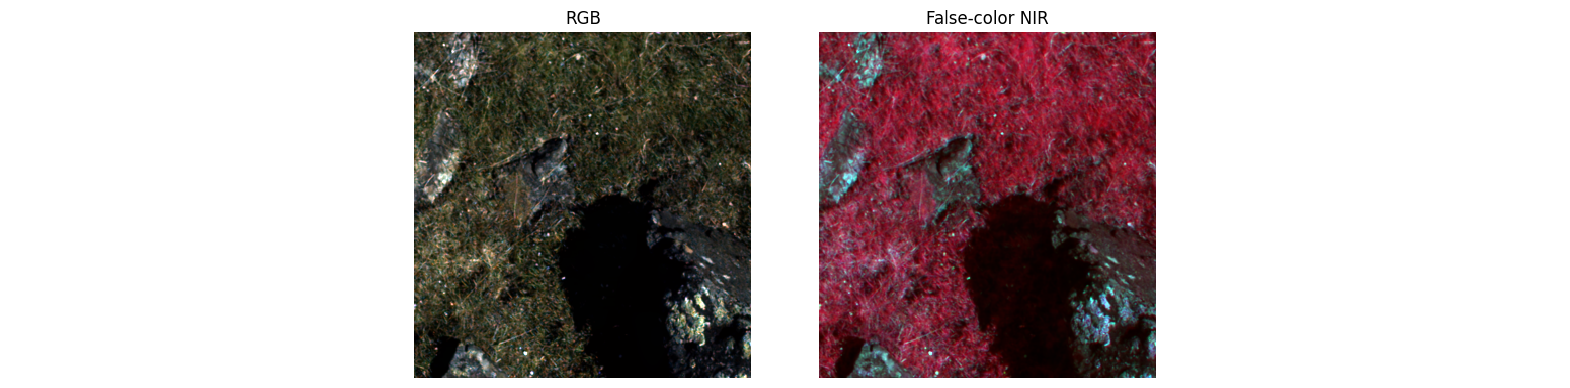

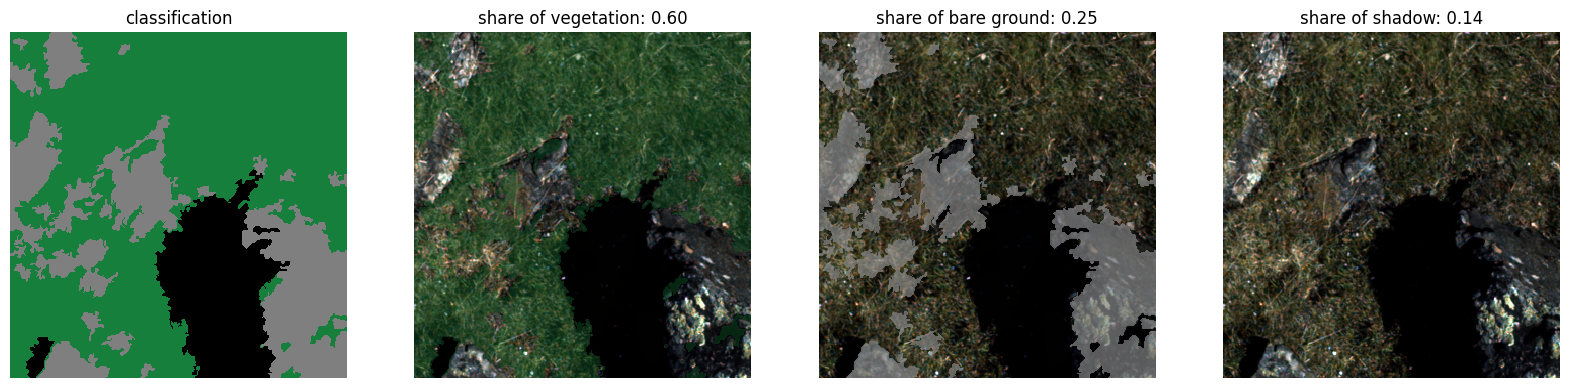

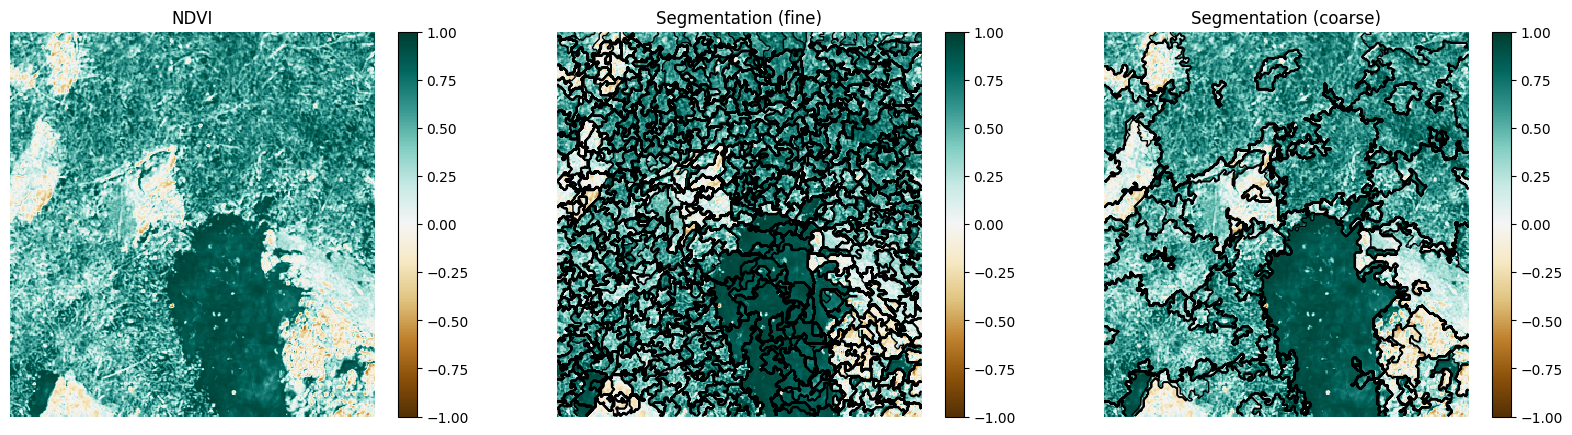

In [101]:
# explorative analyses with plotting
# read paths
plt.style.use("default")
examples = [] 
base_path = "c:/Users/felix/Desktop/internship_letg/data/biomass/point_tiles/all"
np.random.seed(41)
for tile_name in np.random.choice(os.listdir(base_path), 20):
    examples.append(os.path.join(base_path, tile_name))

img = examples[13]
img = rxr.open_rasterio(img)

# get rgb & nir img
bgr = img[:3,:,:]/(2**16)
grnir = img[1:4,:,:]/(2**16)
nir = copy.deepcopy(grnir)
nir[0,:,:], nir[2,:,:] = grnir[2,:,:], grnir[0,:,:]

# calculate ndvi index 
red_band = img[2,:,:]/1
nir_band = img[3,:,:]/1
ndvi = (nir_band - red_band)/(nir_band + red_band)

# segmentation/object creation
# use same scale for shadow retrieval
seg_fine = felzenszwalb(ndvi.to_numpy(), scale=20, min_size=50)
seg_fine = xr.DataArray(seg_fine, coords={'x': ndvi["x"],'y': ndvi["y"]}, dims=["y", "x"])
seg_coarse = felzenszwalb(ndvi.to_numpy(), scale=200, min_size=100)
seg_coarse = xr.DataArray(seg_coarse, coords={'x': ndvi["x"],'y': ndvi["y"]}, dims=["y", "x"])

# object-based filtering for ndvi
# thresholding bases on NDVI difference
# add threshold based on absolute values to exclude shadows (quantify them as well as metric)
def invert_vals(arr):
    arr = arr.fillna(0)
    arr = arr.where(arr == 0, 2)
    arr = arr.where(arr == 2, 1)
    arr = arr.where(arr == 1, np.nan) 
    return arr

shadow_mask = bgr.groupby(seg_coarse).where(bgr.groupby(seg_coarse).map(lambda x: np.mean(np.sum(x, axis=0))) < 0.1)
shadow_mask = shadow_mask.where(np.isnan(shadow_mask), 1)[0,:,:]
ndvi_mask = ndvi.groupby(seg_fine).where(ndvi.groupby(seg_fine).map(func=np.mean) > 0.4)
ndvi_mask = ndvi_mask.where(np.isnan(ndvi_mask), 1)
veg_mask = ndvi_mask * invert_vals(shadow_mask)
soil_mask = invert_vals(ndvi_mask) * invert_vals(shadow_mask) 

# calculate shares
shadow_share = np.count_nonzero(~np.isnan(shadow_mask))/(bgr.size/3)
veg_share = np.count_nonzero(~np.isnan(veg_mask))/(bgr.size/3)
soil_share = np.count_nonzero(~np.isnan(soil_mask))/(bgr.size/3)

# plotting
# input image: rgb & nir
f, ax = plt.subplots(1, 4, figsize=(20, 4.5))
xr.plot.imshow(bgr, ax = ax[1])
ax[1].set(title="RGB")
xr.plot.imshow(nir, ax = ax[2])
ax[2].set(title="False-color NIR")
[axi.set_axis_off() for axi in ax.ravel()];
# output classification
f, ax = plt.subplots(1, 4, figsize=(20, 4.5))
veg_mask.plot(ax=ax[0], cmap='Greens', vmin=0, vmax=1.25, add_colorbar=False)
soil_mask.plot(ax=ax[0], cmap='binary', vmin=0, vmax=2, add_colorbar=False)
shadow_mask.plot(ax=ax[0], cmap='binary', vmin=0, vmax=1, add_colorbar=False)
ax[0].set(title=f"classification")

xr.plot.imshow(bgr, ax = ax[1])
veg_mask.plot(ax=ax[1], cmap='Greens', vmin=0, vmax=1.25, add_colorbar=False, alpha=0.3)
ax[1].set(title=f"share of vegetation: {veg_share:.2f}")

xr.plot.imshow(bgr, ax = ax[2])
soil_mask.plot(ax=ax[2], cmap='binary', vmin=0, vmax=2, add_colorbar=False, alpha=0.7)
ax[2].set(title=f"share of bare ground: {soil_share:.2f}")

xr.plot.imshow(bgr, ax = ax[3])
shadow_mask.plot(ax=ax[3], cmap='binary', vmin=0, vmax=1, add_colorbar=False, alpha=0.7)
ax[3].set(title=f"share of shadow: {shadow_share:.2f}")
[axi.set_axis_off() for axi in ax.ravel()];

# intermediate products
f, ax = plt.subplots(1, 3, figsize=(20, 5))
ndvi.plot(ax=ax[0], cmap='BrBG', vmin=-1, vmax=1)
ax[0].set(title="NDVI")
xr.plot.contour(seg_fine, ax = ax[1], cmap="black", levels=len(np.unique(seg_fine.to_numpy())), linewidths=1)
ndvi.plot(ax=ax[1], cmap='BrBG', vmin=-1, vmax=1)
ax[1].set(title="Segmentation (fine)")
xr.plot.contour(seg_coarse, ax = ax[2], cmap="black", levels=len(np.unique(seg_coarse.to_numpy())), linewidths=1)
ndvi.plot(ax=ax[2], cmap='BrBG', vmin=-1, vmax=1)
ax[2].set(title="Segmentation (coarse)")
[axi.set_axis_off() for axi in ax.ravel()];

# output plots for several tiles -> reliabilibity/plausibility
# initial classification (veg, soil, shadow) -> analyse structure

In [11]:
# systematic feature engineering
# helper functions
def _calc_ndvi(img_path):
    img = rxr.open_rasterio(img_path)
    red_band = img[2,:,:]/1
    nir_band = img[3,:,:]/1
    ndvi = (nir_band - red_band)/(nir_band + red_band)
    return ndvi

def _calc_bgr(img_path):
    img = rxr.open_rasterio(img_path)
    return img[:3,:,:]/(2**16)

def _shape_index(gdf):
    p = gdf.length
    a = gdf.area
    index = p/(4*np.sqrt(a))
    return index

def _invert_vals(arr):
    arr = arr.fillna(0)
    arr = arr.where(arr == 0, 2)
    arr = arr.where(arr == 2, 1)
    arr = arr.where(arr == 1, np.nan) 
    return arr

# main function to extract features
def img_features(img_path, ndvi_thres=0.4, scale=20, min_size=50):
    feats = {}
    ndvi = _calc_ndvi(img_path)
    bgr = _calc_bgr(img_path)
    # perform segmentation
    seg = felzenszwalb(ndvi.to_numpy(), scale=scale, min_size=min_size)
    seg = xr.DataArray(seg, coords={'x': ndvi["x"],'y': ndvi["y"]}, dims=["y", "x"])
    # convert categorial segmentation raster to polygons
    seg_shapes = []
    for _shape, value in rs.features.shapes(np.array(seg, dtype="int"), connectivity=8):
        df = {"seg_id": value, "geometry": shape(_shape)}
        seg_shapes.append(df)
    seg_shape = gpd.GeoDataFrame(seg_shapes)
    # classify raster
    shadow_mask = bgr.groupby(seg).where(bgr.groupby(seg).map(lambda x: np.mean(np.sum(x, axis=0))) < 0.1)
    shadow_mask = shadow_mask.where(np.isnan(shadow_mask), 1)[0,:,:]
    ndvi_mask = ndvi.groupby(seg).where(ndvi.groupby(seg).map(func=np.mean) > ndvi_thres)
    ndvi_mask = ndvi_mask.where(np.isnan(ndvi_mask), 1)
    veg_mask = ndvi_mask * _invert_vals(shadow_mask)
    soil_mask = _invert_vals(ndvi_mask) * _invert_vals(shadow_mask) 
    # calculate spectral features, i.e. landcover shares
    feats["share_shadow"] = np.count_nonzero(~np.isnan(shadow_mask))/ndvi.size
    feats["share_veg"] = np.count_nonzero(~np.isnan(veg_mask))/ndvi.size
    feats["share_soil"] = np.count_nonzero(~np.isnan(soil_mask))/ndvi.size
    # calculate spatial features, i.e. object numbers, sizes & shapes
    feats["seg_n"] = len(np.unique(seg))
    # following features only for vegetation class
    veg_idx = np.unique(seg * veg_mask)[:-1]
    seg_veg = seg_shape[[id in veg_idx for id in seg_shape["seg_id"]]]
    feats["seg_area_mean"] = seg_veg.area.mean()
    feats["seg_area_std"] = seg_veg.area.std()
    shape_idxs = _shape_index(seg_veg)
    feats["seg_shpidx_mean"] = shape_idxs.mean()
    feats["seg_shpidx_std"] = shape_idxs.std()
    return feats

def multiscale_features(img_path, ndvis = [0.3, 0.4, 0.5], seg_params = [(20, 50), (200, 100)]):
    all_feats = []
    set_idx = 1
    for ndvi_thres in ndvis:
        for (scale, min_size) in seg_params:
            img_f = img_features(img_path, ndvi_thres, scale, min_size)
            feat_names = [f"{x}_{set_idx}" for x in img_f.keys()]
            feats = pd.Series(img_f)
            feats.index = feat_names
            all_feats.append(feats)
            set_idx += 1
    all_feats = pd.DataFrame(pd.concat(all_feats)).reset_index()
    all_feats.rename(columns={"index": "feature", 0: "value"}, inplace=True)
    # all_feats["feature_trunc"] = [x.rsplit("_", 1)[0] for x in all_feats["feature"]]
    # all_feats.drop_duplicates(subset=["feature_trunc", "value"], inplace=True)
    return all_feats

In [21]:
# compile features for all tiles
base_path = "c:/Users/felix/Desktop/internship_letg/data/biomass/point_tiles"
tiles_feats = []
for tile_name in tqdm(os.listdir(os.path.join(base_path, "all"))):
    tile_path = os.path.join(base_path, "all", tile_name)
    tile_feats = multiscale_features(tile_path)
    tile_feats["tile_name"] = os.path.split(tile_path)[-1].split(".tif")[0]
    tiles_feats.append(tile_feats)
tiles_feats = pd.concat(tiles_feats)
tiles_feats = tiles_feats.pivot_table(columns="feature", index="tile_name", values="value").reset_index()
tiles_feats.fillna(0, inplace=True)

100%|██████████| 160/160 [26:35<00:00,  9.97s/it]


In [81]:
# prepare df as rf input
in_situ_meas = pd.read_csv(os.path.join(base_path, "meas_tiles.csv")).iloc[:,[0,15,16,17]]
in_situ_meas = in_situ_meas.rename(columns = {
    "Hauteur moyenne vegetation (cm)":"height",
    "Volume de la vegetation (m3)":"volume",
    "Recouvrement de vegetation (%)":"coverage",
})
tiles_df = pd.merge(in_situ_meas, tiles_feats, left_on="JETON", right_on="tile_name")
tiles_df = tiles_df.drop(columns="JETON")
tiles_df.set_index("tile_name", inplace=True)
tiles_df.to_csv("c:/Users/felix/Desktop/internship_letg/results/rf_baseline/feature_df.csv")
tiles_df

,height,volume,coverage,seg_area_mean_1,seg_area_mean_2,seg_area_mean_3,seg_area_mean_4,seg_area_mean_5,seg_area_mean_6,seg_area_std_1,...,share_soil_3,share_soil_4,share_soil_5,share_soil_6,share_veg_1,share_veg_2,share_veg_3,share_veg_4,share_veg_5,share_veg_6
tile_name,,,,,,,,,,,,,,,,,,,,,
P1c,4.0,1.00,25.0,188.345395,937.602941,189.774590,1140.189189,186.520468,1416.000000,108.248655,...,0.545681,0.600628,0.675631,0.763989,0.516345,0.574962,0.417580,0.380444,0.287630,0.217082
P2c,30.0,22.50,75.0,188.981818,1034.694444,189.485465,1136.050000,188.281481,1463.000000,116.486597,...,0.255318,0.241981,0.384700,0.355328,0.656134,0.671825,0.587822,0.614696,0.458440,0.501348
P3c,2.0,0.02,1.0,175.428571,247.357143,196.000000,338.333333,0.000000,122.000000,78.428521,...,0.886923,0.883072,0.890458,0.900279,0.022148,0.031229,0.003535,0.018307,0.000000,0.001100
P4c,1.0,0.01,1.0,136.000000,192.200000,87.000000,166.333333,87.000000,0.000000,43.092923,...,0.990369,0.991451,0.990369,0.995951,0.003679,0.008666,0.000785,0.004500,0.000785,0.000000
P5c,7.0,5.60,80.0,196.441926,534.440559,195.812298,576.750000,190.068548,603.407407,118.284459,...,0.422197,0.404612,0.542759,0.546375,0.625346,0.689203,0.545645,0.582528,0.425083,0.440765
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CH61c,19.0,11.40,60.0,169.276190,2050.355556,173.463415,2605.580645,173.845109,3340.363636,107.827850,...,0.293898,0.271587,0.422468,0.337283,0.801432,0.832057,0.705498,0.728413,0.576928,0.662717
CH62c,5.0,0.50,10.0,161.122449,385.357143,171.517241,409.000000,196.105263,489.285714,108.051422,...,0.949292,0.950644,0.960546,0.964018,0.071197,0.048652,0.044856,0.044260,0.033601,0.030887
CH64c,23.0,16.10,70.0,172.289600,2745.150000,173.343154,3209.562500,171.859127,4737.450000,104.736931,...,0.098026,0.073795,0.218886,0.145551,0.971070,0.990233,0.901974,0.926205,0.781114,0.854449


In [42]:
# t.b.d: random forest regressor 
# adjusted to pytorch image dataloader folder structure
    # var
        # train
            # value
                # sample 1
                # sample 2
                # ...
            # ...
        # val
        # test

In [191]:
# rf regressor
class rf_base:
    def __init__(self, portions_df, var_exp, only_spectral_features=False):
        # get train-val-test portions
        self.portions_data = portions_df
        self.train_tiles = self.portions_data[self.portions_data["portion"] == "train"]["tile_name"]
        self.val_tiles = self.portions_data[self.portions_data["portion"] == "val"]["tile_name"]
        self.test_tiles = self.portions_data[self.portions_data["portion"] == "test"]["tile_name"]
        # get features & labels
        self.in_data = tiles_df
        feats = self.in_data.columns[[x not in ["tile_name", "height", "volume", "coverage"] for x in self.in_data.columns]]
        if only_spectral_features:
            feats = feats[["share" in x for x in feats]]
        # get features & labels for each portion 
        self.X_train = self.in_data[self.in_data["tile_name"].isin(self.train_tiles)][feats]
        self.X_val = self.in_data[self.in_data["tile_name"].isin(self.val_tiles)][feats]
        self.X_test = self.in_data[self.in_data["tile_name"].isin(self.test_tiles)][feats]
        self.y_train = self.in_data[self.in_data["tile_name"].isin(self.train_tiles)][var_exp]
        self.y_val = self.in_data[self.in_data["tile_name"].isin(self.val_tiles)][var_exp]
        self.y_test = self.in_data[self.in_data["tile_name"].isin(self.test_tiles)][var_exp]
        
    def train_predict(self, seed=44):
        self.mod = RandomForestRegressor(random_state = seed).fit(self.X_train, self.y_train)
        self.y_pred_val = self.mod.predict(self.X_val)
        self.y_pred_test = self.mod.predict(self.X_test)

    def evaluate(self):
        warnings.filterwarnings("ignore", category=UserWarning)
        accs = metrics.MetricCollection([
        metrics.MeanAbsoluteError(),
        metrics.MeanSquaredError(),
        metrics.PearsonCorrCoef(),
        metrics.SpearmanCorrCoef(),
        metrics.R2Score()
        ])
        # compute val metrics
        accs.update(Tensor(self.y_pred_val), Tensor(np.array(self.y_val)))
        self.val_acc = accs.compute()
        self.val_acc = {k:float(v.numpy()) for k,v in self.val_acc.items()}
        accs.reset()
        # compute test metrics
        accs.update(Tensor(self.y_pred_test), Tensor(np.array(self.y_test)))
        self.test_acc = accs.compute()
        self.test_acc = {k:float(v.numpy()) for k,v in self.test_acc.items()}
        accs.reset()

In [244]:
# correlation between val & test error? -> yes (0.3)
# leaving out some variables -> spectral feats done
# systematic test across all splits & vars -> currently implementing, translate to py for server

In [274]:
splits_res = {}
split_path = "C:/Users/felix/Desktop/internship_letg/data/biomass/point_tiles/splits/split_1"
split_nr = os.path.split(split_path)[1]
for var in ["coverage", "height", "volume"]:
    # get train - val- test data
    tile_splits = []
    split_path_var = os.path.join(split_path, var)
    for path, subdirs, files in os.walk(split_path_var):
        if len(files):
            for file in files:
                portion = os.path.split(os.path.dirname(path))[1]
                tile_name = file.split(".tif")[0]
                tile_splits.append(pd.Series({"portion": portion, "tile_name": tile_name}))
    tile_splits = pd.DataFrame(tile_splits)
    # perform multiple rf tests
    runs = []
    for seed in np.arange(0, 5):
        rf = rf_base(tile_splits, var)
        rf.train_predict(seed)
        rf.evaluate()
        run_accs = pd.Series({
        "seed": seed,
        "acc_val": rf.val_acc["MeanAbsoluteError"],
        "acc_test": rf.test_acc["MeanAbsoluteError"],
        })
        runs.append(run_accs)
    runs = pd.DataFrame(runs) 
    best_mod_idx = int(runs.iloc[runs.idxmin()["acc_val"], :]["seed"])
    # get best result per run
    rf = rf_base(tile_splits, var)
    rf.train_predict(best_mod_idx)
    rf.evaluate()
    # write accuracies to summarising df
    splits_res[f"{split_nr}_{var}"] = rf.test_acc

In [275]:
splits_res = pd.DataFrame(splits_res).reset_index()
splits_res = splits_res.melt(id_vars="index")
splits_res["split"] = [x.rsplit("_",1)[0] for x in splits_res["variable"]]
splits_res["variable"] = [x.rsplit("_",1)[1] for x in splits_res["variable"]]
splits_res.pivot(index=["variable","split"], columns="index", values="value").reset_index()
splits_res

,index,variable,value,split
0,MeanAbsoluteError,coverage,8.308333,split_1
1,MeanSquaredError,coverage,92.814980,split_1
2,PearsonCorrCoef,coverage,0.959310,split_1
3,SpearmanCorrCoef,coverage,0.876684,split_1
4,R2Score,coverage,0.915211,split_1
5,MeanAbsoluteError,height,6.115834,split_1
6,MeanSquaredError,height,84.666489,split_1
7,PearsonCorrCoef,height,0.677582,split_1
8,SpearmanCorrCoef,height,0.750877,split_1
9,R2Score,height,0.440369,split_1
